# Генерация лиц

## Импорт библиотек

In [1]:
import os

import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt

## Загрузка и подготовка данных

In [2]:
# Распакуем
!unzip frey_rawface.zip
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Archive:  frey_rawface.zip
  inflating: frey_rawface.mat        
Number of instances: 1965


In [3]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

In [4]:
x_train = FreyDataset(data[:-300])
x_val = FreyDataset(data[-300:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [5]:
BATCH_SIZE = 32

train_loader = DataLoader(
    dataset=x_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=os.cpu_count(),
    drop_last=True
    )

val_loader = DataLoader(
    dataset=x_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
    num_workers=os.cpu_count(),
    drop_last=True
    )

In [6]:
KERNEL_SIZE = 4
STRIDE = 1
PADDING = 0
INIT_KERNEL = 16

## Вариационныей автоэнкодер

In [7]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # энкодер
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=INIT_KERNEL,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.enc2 = nn.Conv2d(
            in_channels=INIT_KERNEL, out_channels=INIT_KERNEL*2,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.enc3 = nn.Conv2d(
            in_channels=INIT_KERNEL*2, out_channels=INIT_KERNEL*4,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.enc4 = nn.Conv2d(
            in_channels=INIT_KERNEL*4, out_channels=INIT_KERNEL*8,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.enc5 = nn.Conv2d(
            in_channels=INIT_KERNEL*8, out_channels=INIT_KERNEL,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        # декодер
        self.dec1 = nn.ConvTranspose2d(
            in_channels=INIT_KERNEL, out_channels=INIT_KERNEL*8,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=INIT_KERNEL*8, out_channels=INIT_KERNEL*4,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=INIT_KERNEL*4, out_channels=INIT_KERNEL*2,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=INIT_KERNEL*2, out_channels=INIT_KERNEL,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=INIT_KERNEL, out_channels=1,
            kernel_size=KERNEL_SIZE, stride=STRIDE, padding=PADDING
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        sample = mu + eps * std
        return sample

    def forward(self, x):
        # кодирование
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = self.enc5(x)
        # сэмплирование среднего и logvar
        mu = x
        log_var = x
        # получаем латентное предстваление через репораметризацию
        z = self.reparameterize(mu, log_var)

        # декодирование
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

In [8]:
lr = 0.001
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

## Функция потерь VAE

In [10]:
def VAE_loss(bce_loss, mu, logvar):
    # Ошибка бинарной кросс-энтропии
    BCE = bce_loss
    # Дивергенция Кульбака-Лейблера
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Обучение модели

In [11]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(
        enumerate(dataloader),
        total=int(len(x_train)/dataloader.batch_size)
        ):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = VAE_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [12]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total=int(len(x_val)/dataloader.batch_size)
            ):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = VAE_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8],
                                  reconstruction[:8]))
                save_image(
                    both.cpu(), f"./output{epoch}.png", nrow=num_rows
                    )
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [13]:
train_losses = []
val_losses = []
REP_FREQ = 5
for epoch in range(epochs):
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    if epoch % REP_FREQ == 0:
        print(f"Epoch {epoch+1} of {epochs}")
        print(f"Train Loss: {train_epoch_loss:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}")

  0%|          | 0/52 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATe

Epoch 1 of 20
Train Loss: 365.8261
Val Loss: 338.7199



100%|██████████| 9/9 [00:00<00:00, 71.95it/s]

Epoch 6 of 20
Train Loss: 352.3481
Val Loss: 336.8643



100%|██████████| 9/9 [00:00<00:00, 71.50it/s]

Epoch 11 of 20
Train Loss: 352.1812
Val Loss: 336.4518



100%|██████████| 9/9 [00:00<00:00, 100.42it/s]

Epoch 16 of 20
Train Loss: 352.1505
Val Loss: 337.2102



100%|██████████| 9/9 [00:00<00:00, 86.08it/s]


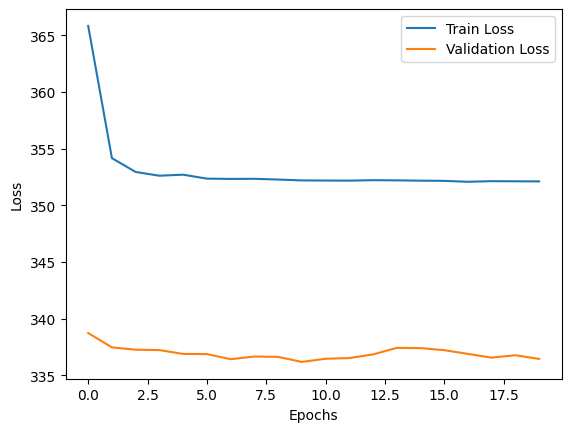

In [17]:
# Визуализация динамики потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Визуализация полученных изображений

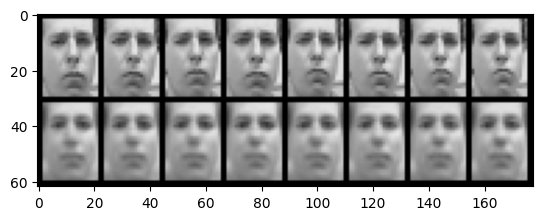

In [15]:
# 10я эпоха
image_10 = Image.open("output10.png")
plt.imshow(image_10)

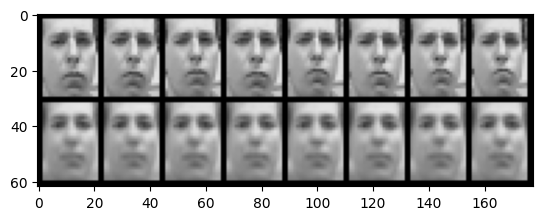

In [16]:
# 19я эпоха
image_19 = Image.open("output19.png")
plt.imshow(image_19)